In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
csv_2018 = 'kickstarter-projects/ks-projects-201801.csv'
df = pd.read_csv(csv_2018, encoding="ISO-8859-1")

df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
# remove errors in data, or extra stuff i dont need
df = df[df.state.isin(['failed', 'successful', 'canceled', 'suspended'])]
df = df[df['country'] != 'N,0"']
# change deadline & launched to datetime
deadline_series = pd.to_datetime(df.deadline)
launched_series = pd.to_datetime(df.launched)
df.deadline = deadline_series
df.launched = launched_series
# taking out "joke" campaigns
conf_int = np.percentile(df['usd_goal_real'], [.1, 99.9])
df_just_out = df[df['usd_goal_real'] > conf_int[1]]
df_no_out = df[df['usd_goal_real'] < conf_int[1]]
df = df_no_out 
# tossing all projects that raised no money

df = df[df['pledged'] != 0]
# focusing on usd
df_just_usd = df[df['currency'] == 'USD']
df = df_just_usd 
# take out weird data
kickstarter_begins = pd.Timestamp(year=2009, month=4, day=9, hour=0) # datetime.date(2009, 4, 9)
df = df[df['launched'] > kickstarter_begins ]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252844 entries, 1 to 378660
Data columns (total 15 columns):
ID                  252844 non-null int64
name                252842 non-null object
category            252844 non-null object
main_category       252844 non-null object
currency            252844 non-null object
deadline            252844 non-null datetime64[ns]
goal                252844 non-null float64
launched            252844 non-null datetime64[ns]
pledged             252844 non-null float64
state               252844 non-null object
backers             252844 non-null int64
country             252844 non-null object
usd pledged         252844 non-null float64
usd_pledged_real    252844 non-null float64
usd_goal_real       252844 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(2), object(6)
memory usage: 30.9+ MB


In [4]:
df['percent_raised'] = df['pledged'] / df['goal']
def fill_100(row):
    if row['percent_raised'] > 1:
        return 1
    else: 
        return row['percent_raised']
df['percent_raised'] = df.apply(lambda x: fill_100(x), axis=1)
#df['percent_raised']

In [5]:
state = df.state.value_counts()
percent_success = (state['successful'] / len(df)) * 100
percent_success

43.22784009112338

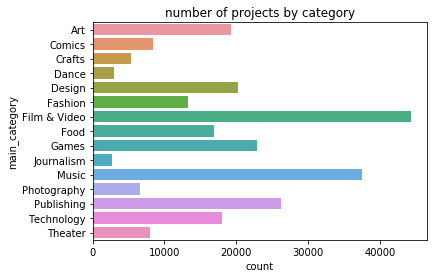

In [6]:
# category count
df = df.sort_values(by='main_category')
_ = sns.countplot(y='main_category', data=df)
plt.title('number of projects by category')
plt.savefig('plots/cat_count.png')

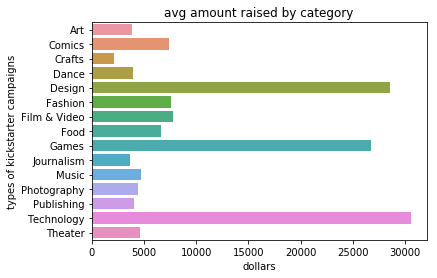

In [7]:
# total money raised by category
money_raised = df.groupby(['main_category'])['pledged'].mean()
raised_df = pd.DataFrame(money_raised).reset_index()
raised_df = raised_df.astype(object)
#raised_df
#raised_df.head()
_ = sns.barplot(x="pledged", y="main_category", data=raised_df, errwidth=0)

plt.title('avg amount raised by category')
plt.xlabel('dollars')
plt.ylabel('types of kickstarter campaigns')

plt.savefig('plots/ave_raised_cat.png')

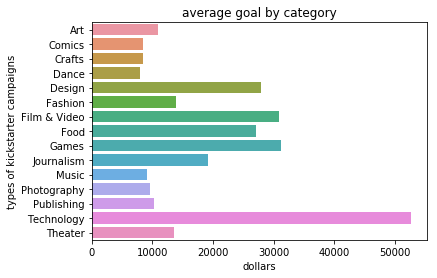

In [8]:
# how high is the goal by category

money_goal = df.groupby(['main_category'])['goal'].mean()
goal_df = pd.DataFrame(money_goal).reset_index()
goal_df = goal_df.astype(object)
#goal_df
#raised_df.head()
_ = sns.barplot(x="goal", y="main_category", data=goal_df, errwidth=0)
plt.ticklabel_format(style='plain', axis='x')
plt.title('average goal by category')
plt.xlabel('dollars')
plt.ylabel('types of kickstarter campaigns')
plt.savefig('plots/ave_goal_cat.png')

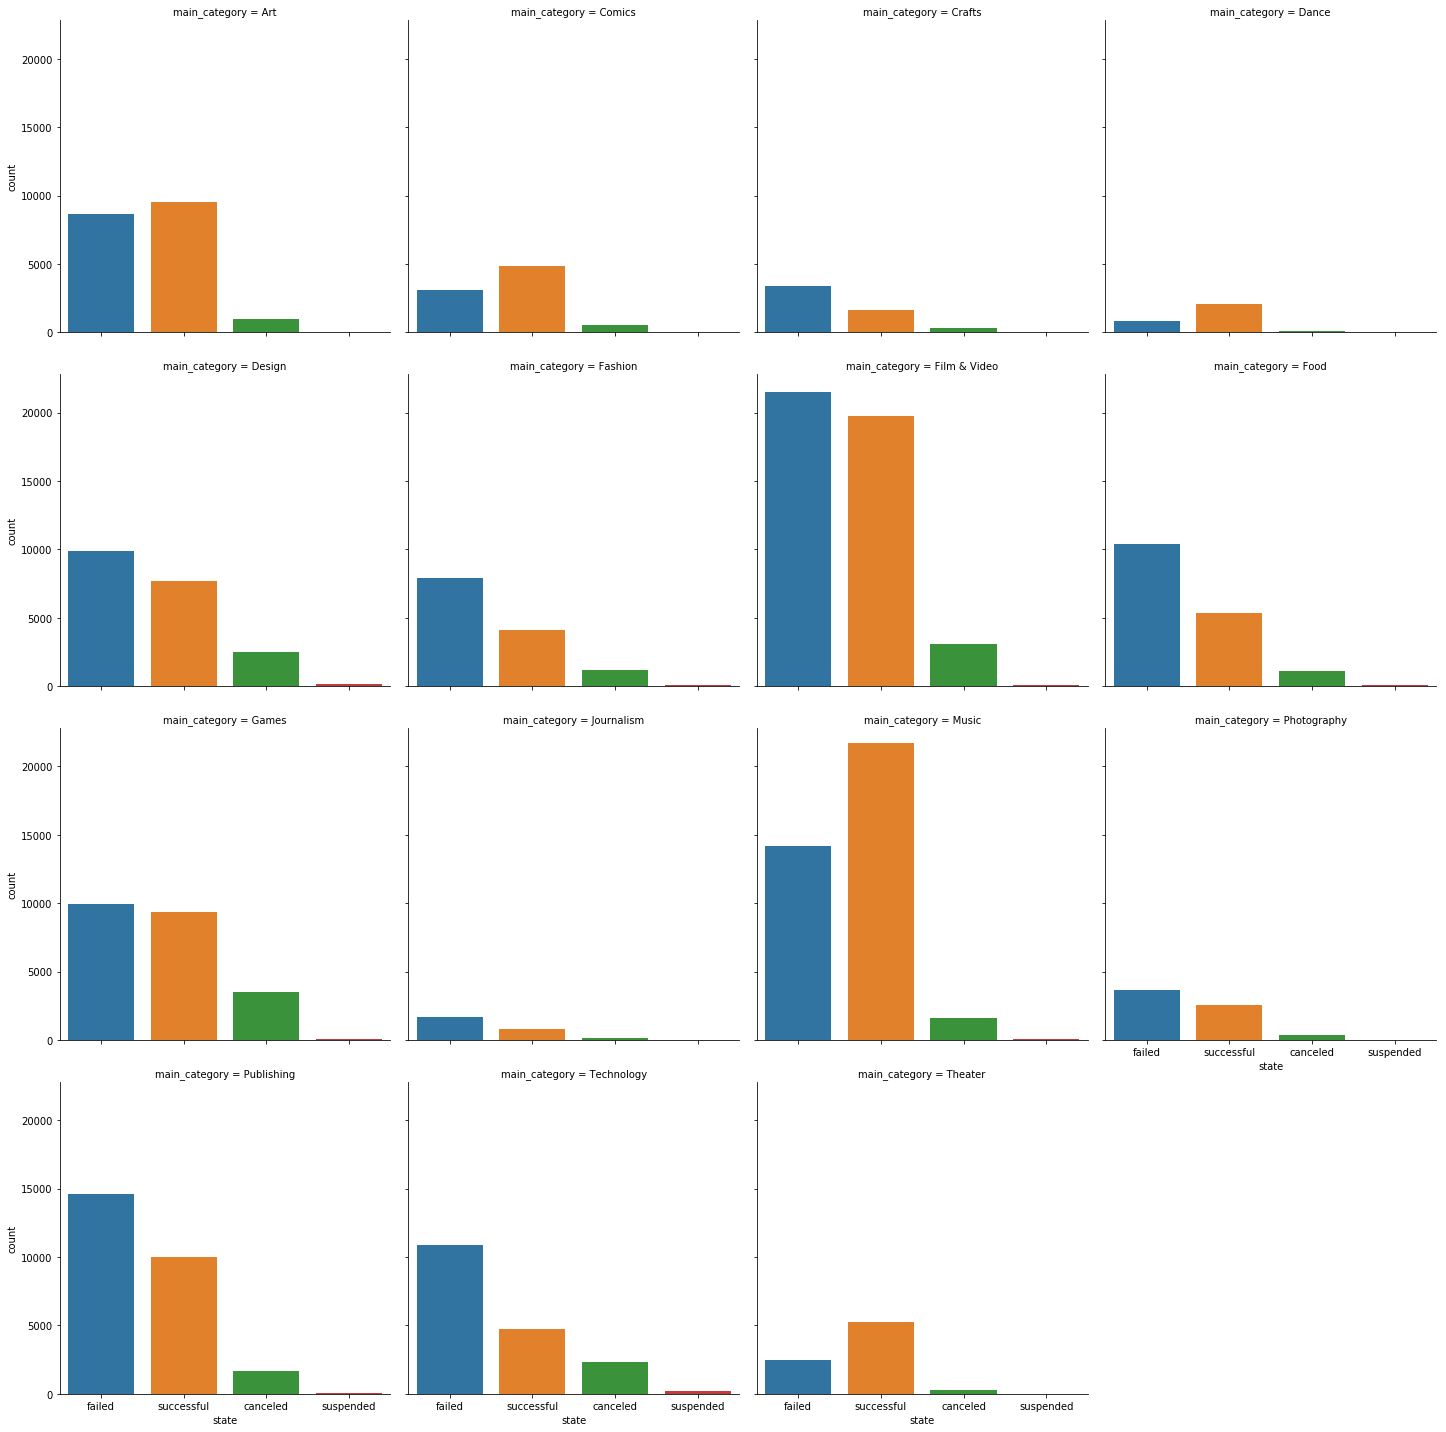

In [9]:
_ = sns.catplot("state", col="main_category", col_wrap=4, data=df,kind="count")


In [10]:
df2 = df[['main_category', 'state']]
group = df2.groupby(['main_category', 'state'])['state'].count()


In [11]:
ratio = {}
for i, k in group.keys():
    ratio[i] = group[i].successful / (group[i].canceled + group[i].failed + group[i].suspended + group[i].successful) 
    
sorted_ratio = {}
for w in sorted(ratio, key=ratio.get, reverse=True):
    sorted_ratio[w] = ratio[w]

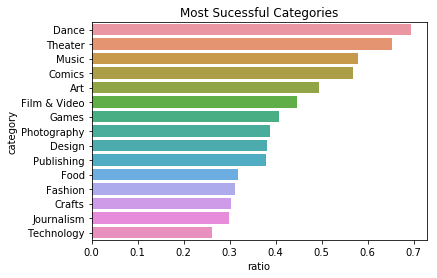

In [12]:

ratio_df = pd.DataFrame(list(sorted_ratio.items()), columns=['category', 'ratio'])
#ratio_df
_ = sns.barplot(x="ratio", y="category", data=ratio_df)
plt.title('Most Sucessful Categories')
plt.savefig('plots/type_ratios.png')

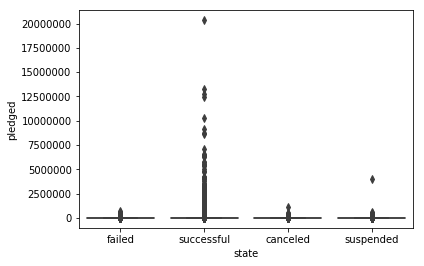

In [13]:
_ = sns.boxplot(x='state', y='pledged', data=df)
plt.ticklabel_format(style='plain', axis='y')

In [14]:
from scipy import stats
import statsmodels.stats.weightstats as ws
import statsmodels.stats.multicomp as mc 
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [15]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1)/ len(x)
    return x, y
#defining fuction to obtain replicates of bootstrap samples
def bs_replicate_samples(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_replicate(data, func, size=1):
    #obtaining random bootstrap samples
    
    bs_replicate = np.empty(size)
    
    for i in range(size):
        bs_replicate[i] = bs_replicate_samples(data, func)
        
    return bs_replicate

In [16]:
df['goal_diff'] = df['pledged'] - df['goal']

df['dollars_per_backer'] = df['pledged'] / df['backers']
df.loc[~np.isfinite(df['dollars_per_backer']), 'dollars_per_backer'] = 0
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,percent_raised,goal_diff,dollars_per_backer
378660,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2000.000,2011-07-19 09:07:47,524.000,failed,17,US,524.000,524.000,2000.000,0.262,-1476.000,30.824
64396,1327501769,Carving Cultural Connection,Public Art,Art,USD,2011-10-01,15000.000,2011-09-01 19:53:20,210.000,failed,4,US,210.000,210.000,15000.000,0.014,-14790.000,52.500
274345,466130349,Blood/Sailing,Performance Art,Art,USD,2012-07-28,3000.000,2012-06-04 22:03:06,3056.690,successful,72,US,3056.690,3056.690,3000.000,1.000,56.690,42.454
64385,1327449173,Eclectic Art from the Forgotten Vaults of Yest...,Mixed Media,Art,USD,2014-01-08,5000.000,2013-12-09 10:30:19,12.000,failed,1,US,12.000,12.000,5000.000,0.002,-4988.000,12.000
274364,46623362,Ceramic Celtic Cups and Teapots,Ceramics,Art,USD,2014-04-05,450.000,2014-03-06 20:19:47,766.360,successful,27,US,766.360,766.360,450.000,1.000,316.360,28.384


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


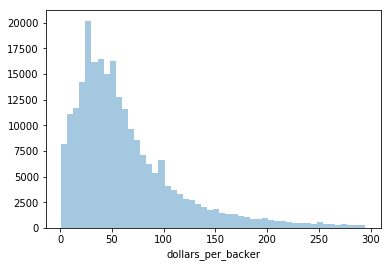

In [17]:
df2 = df[df['dollars_per_backer'] > 1]
df2 = df[df['dollars_per_backer'] < 10000]
per = np.percentile(df['dollars_per_backer'], [2.5, 97.5])
per
df2 = df[df['dollars_per_backer'] < per[1]]
df2 = df2[df2['dollars_per_backer'] > per[0]]
df2.describe()
_ = sns.distplot(df2['dollars_per_backer'], kde=False)

In [18]:
df2.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,percent_raised,goal_diff,dollars_per_backer
count,238165.000,238165.000,238165.000,238165.000,238165.000,238165.000,238165.000,238165.000,238165.000,238165.000
mean,1074965338.314,19434.121,10326.373,135.247,8266.447,10326.373,19434.121,0.514,-9107.747,63.961
std,618864673.993,79464.872,101249.303,1087.381,90503.349,101249.303,79464.872,0.454,121381.885,51.362
min,5971.000,0.010,1.010,1.000,0.000,1.010,0.010,0.000,-3299650.000,1.002
25%,538199820.000,2000.000,191.000,5.000,125.000,191.000,2000.000,0.037,-8264.000,28.500
50%,1076370145.000,5000.000,1281.000,23.000,960.000,1281.000,5000.000,0.361,-865.000,50.000
75%,1610531668.000,15000.000,5327.000,76.000,4348.000,5327.000,15000.000,1.000,405.000,82.995
max,2147476221.000,3300000.000,20338986.270,219382.000,20338986.270,20338986.270,3300000.000,1.000,19838986.270,294.962


In [19]:
# since we have some pretty huge outliers, we will strip away the highest 1 percent of raising
per = np.percentile(df2['dollars_per_backer'], [0, 25, 50, 75, 95, 100])

df_0_25 = df2[df2['dollars_per_backer'].between(per[0], per[1])]
df_25_50 = df2[df2['dollars_per_backer'].between(per[1], per[2])]
df_50_75 = df2[df2['dollars_per_backer'].between(per[2], per[3])]
df_75_95 = df2[df2['dollars_per_backer'].between(per[3], per[4])]
df_95_100 = df2[df2['dollars_per_backer'].between(per[4], per[5])]
df_0_25.describe()
#df_no_out = df[df['pledged'] < per[1]]
#df_no_out.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,percent_raised,goal_diff,dollars_per_backer
count,59586.000,59586.000,59586.000,59586.000,59586.000,59586.000,59586.000,59586.000,59586.000,59586.000
mean,1073286042.566,19193.968,1241.450,57.674,1045.203,1241.450,19193.968,0.227,-17952.517,16.978
std,618777527.919,92266.237,10654.461,445.350,9285.064,10654.461,92266.237,0.377,92878.249,7.641
min,18520.000,0.010,1.010,1.000,0.000,1.010,0.010,0.000,-2999996.000,1.002
25%,539160665.250,1000.000,21.000,2.000,18.000,21.000,1000.000,0.003,-9960.000,10.000
50%,1070303781.500,3500.000,60.000,4.000,51.000,60.000,3500.000,0.020,-2945.000,18.000
75%,1611224930.750,10000.000,272.000,14.000,223.000,272.000,10000.000,0.200,-470.000,24.300
max,2147394426.000,3000000.000,1022120.700,36863.000,702516.410,1022120.700,3000000.000,1.000,1012120.700,28.500


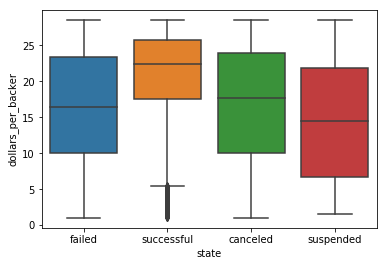

In [49]:
#p = stats.normaltest(df_0_25['pledged'])
# x_0_25, y_0_25 = ecdf(df_0_25['pledged'])
_ = sns.boxplot(x='state', y='dollars_per_backer', data=df_0_25)
#= sns.boxplot(x='state', y='pledged', data=df_0_25)
plt.savefig('plots/dollars_per_backer_by_state')


In [ ]:
# see if dollars per backer is signicantly different depending on succesful or not

In [33]:
df_fail = df2[df2['state']!='sucessful']
df_succeed = df2[df2['state'] == 'successful']
#df_succeed.head()
#np.mean(df_succeed.dollars_per_backer)
diff_mean = np.mean(df_succeed.dollars_per_backer) - np.mean(df_fail.dollars_per_backer)



In [34]:
obs_mean = np.mean(df2.dollars_per_backer)

#generating shifted arrays
fail_shifted = df_fail.dollars_per_backer - np.mean(df_fail.dollars_per_backer) + obs_mean
succeed_shifted = df_succeed.dollars_per_backer - np.mean(df_succeed.dollars_per_backer) + obs_mean
# print(np.mean(succeed_shifted), np.mean(fail_shifted))

bs_fail = draw_bs_replicate(fail_shifted, np.mean, 10000)
bs_success = draw_bs_replicate(succeed_shifted, np.mean, 10000)

#getting replicates of differences of mean
bs_diff = bs_success - bs_fail 

p_diff = np.sum(bs_diff >= diff_mean)/len(bs_diff)

p_diff

0.0

In [ ]:
# does high dollar per backer indicate sucessful campaigns

In [35]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [36]:
a = df2['main_category'].value_counts()

for i in a.keys():
    print(i)

Film & Video
Music
Publishing
Games
Design
Art
Food
Technology
Fashion
Comics
Theater
Photography
Crafts
Dance
Journalism


In [37]:
# see if the percent raised mean is different by category
df2['main_category'].value_counts()

Film & Video    41808
Music           35928
Publishing      24992
Games           22047
Design          18852
Art             18386
Food            15621
Technology      15567
Fashion         12270
Comics           8358
Theater          7742
Photography      6222
Crafts           5035
Dance            2912
Journalism       2425
Name: main_category, dtype: int64

In [38]:
a, p = stats.f_oneway(df2[df2['main_category'] == 'Film & Video']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Music']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Publishing']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Games']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Design']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Art']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Food']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Technology']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Fashion']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Comics']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Theater']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Photography']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Crafts']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Dance']['dollars_per_backer'],
                      df2[df2['main_category'] == 'Journalism']['dollars_per_backer'])
print(p, a)

0.0 654.1232292437012


In [39]:
mc2 = MultiComparison(df2['dollars_per_backer'], df2['main_category'])
result2 = mc2.tukeyhsd()
 
print(result2)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
   group1       group2    meandiff  lower    upper   reject
-----------------------------------------------------------
    Art         Comics    -15.4839 -17.739  -13.2288  True 
    Art         Crafts    -14.5236 -17.2426 -11.8047  True 
    Art         Dance     13.9231  10.5138  17.3325   True 
    Art         Design    13.0417  11.2699  14.8135   True 
    Art        Fashion     6.9394   4.9468   8.9321   True 
    Art      Film & Video 17.1234  15.6107  18.6361   True 
    Art          Food      8.6423   6.7822  10.5024   True 
    Art         Games     -9.1208  -10.828  -7.4136   True 
    Art       Journalism  -6.4766  -10.1697 -2.7835   True 
    Art         Music      4.6317   3.0816   6.1817   True 
    Art      Photography   1.4635  -1.0437   3.9706  False 
    Art       Publishing  -5.4668  -7.1277   -3.806   True 
    Art       Technology  15.4045  13.5427  17.2664   True 
    Art        Theater    11.3386   9.02

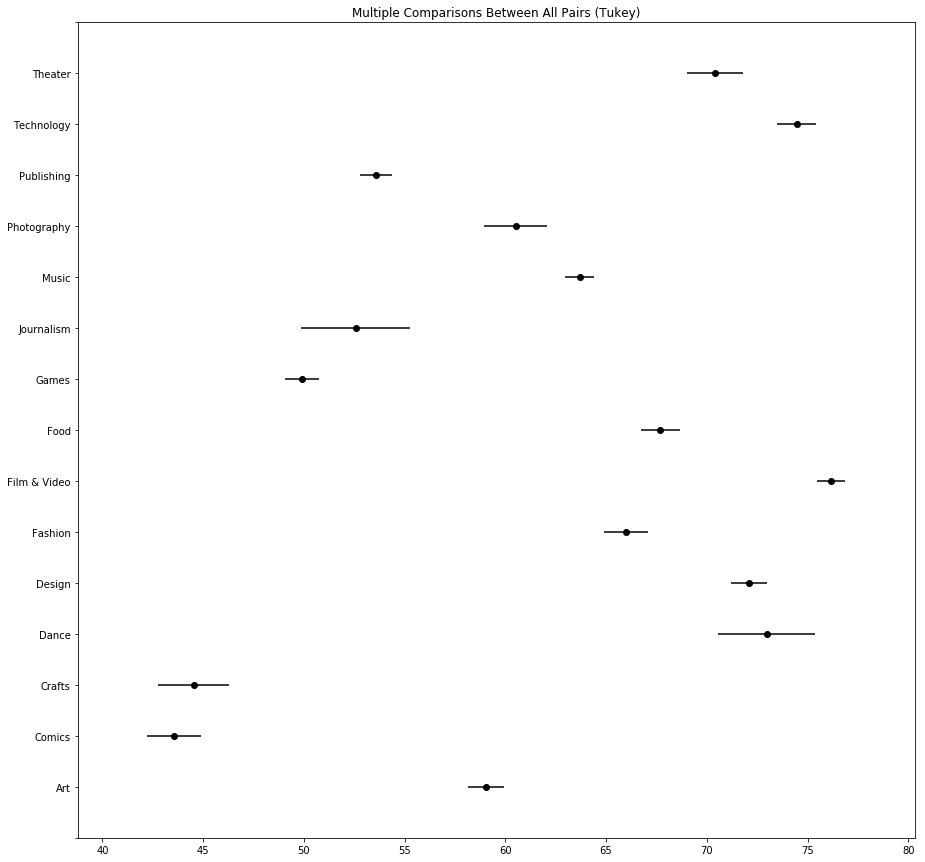

In [50]:
_ = result2.plot_simultaneous(figsize=(15, 15))
plt.savefig('plots/tukey_dollar_per_backer')

In [43]:
diff_mean_goal =  np.mean(df_fail.goal) - np.mean(df_succeed.goal)
print(diff_mean_goal)

10377.790879704618


In [44]:
obs_mean_goal = np.mean(df2.goal)
print(obs_mean_goal)

19434.12055260006


In [ ]:
# see if there is a difference between sucessful and unsucessful goals

In [45]:
#generating shifted arrays
fail_shifted_goal = df_fail.goal - np.mean(df_fail.goal) + obs_mean
succeed_shifted_goal = df_succeed.goal - np.mean(df_succeed.goal) + obs_mean_goal
# print(np.mean(succeed_shifted), np.mean(fail_shifted))

bs_fail_goal = draw_bs_replicate(fail_shifted_goal, np.mean, 10000)
bs_success_goal = draw_bs_replicate(succeed_shifted_goal, np.mean, 10000)

#getting replicates of differences of mean
bs_diff_goal =  bs_fail_goal - bs_success_goal

p_diff_goal = np.sum(bs_diff_goal >= diff_mean_goal)/len(bs_diff_goal)

p_diff_goal

0.0

In [46]:
df2.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,percent_raised,goal_diff,dollars_per_backer
378660,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2000.000,2011-07-19 09:07:47,524.000,failed,17,US,524.000,524.000,2000.000,0.262,-1476.000,30.824
64396,1327501769,Carving Cultural Connection,Public Art,Art,USD,2011-10-01,15000.000,2011-09-01 19:53:20,210.000,failed,4,US,210.000,210.000,15000.000,0.014,-14790.000,52.500
274345,466130349,Blood/Sailing,Performance Art,Art,USD,2012-07-28,3000.000,2012-06-04 22:03:06,3056.690,successful,72,US,3056.690,3056.690,3000.000,1.000,56.690,42.454
64385,1327449173,Eclectic Art from the Forgotten Vaults of Yest...,Mixed Media,Art,USD,2014-01-08,5000.000,2013-12-09 10:30:19,12.000,failed,1,US,12.000,12.000,5000.000,0.002,-4988.000,12.000
274364,46623362,Ceramic Celtic Cups and Teapots,Ceramics,Art,USD,2014-04-05,450.000,2014-03-06 20:19:47,766.360,successful,27,US,766.360,766.360,450.000,1.000,316.360,28.384


In [ ]:
# does length of campaign impact success rate

In [47]:
df2['length_of_campaign'] = df2['deadline'] - df2['launched']
df2.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,percent_raised,goal_diff,dollars_per_backer,length_of_campaign
378660,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2000.000,2011-07-19 09:07:47,524.000,failed,17,US,524.000,524.000,2000.000,0.262,-1476.000,30.824,27 days 14:52:13
64396,1327501769,Carving Cultural Connection,Public Art,Art,USD,2011-10-01,15000.000,2011-09-01 19:53:20,210.000,failed,4,US,210.000,210.000,15000.000,0.014,-14790.000,52.500,29 days 04:06:40
274345,466130349,Blood/Sailing,Performance Art,Art,USD,2012-07-28,3000.000,2012-06-04 22:03:06,3056.690,successful,72,US,3056.690,3056.690,3000.000,1.000,56.690,42.454,53 days 01:56:54
64385,1327449173,Eclectic Art from the Forgotten Vaults of Yest...,Mixed Media,Art,USD,2014-01-08,5000.000,2013-12-09 10:30:19,12.000,failed,1,US,12.000,12.000,5000.000,0.002,-4988.000,12.000,29 days 13:29:41
274364,46623362,Ceramic Celtic Cups and Teapots,Ceramics,Art,USD,2014-04-05,450.000,2014-03-06 20:19:47,766.360,successful,27,US,766.360,766.360,450.000,1.000,316.360,28.384,29 days 03:40:13


In [48]:
df2.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,percent_raised,goal_diff,dollars_per_backer,length_of_campaign
count,238165.000,238165.000,238165.000,238165.000,238165.000,238165.000,238165.000,238165.000,238165.000,238165.000,238165
mean,1074965338.314,19434.121,10326.373,135.247,8266.447,10326.373,19434.121,0.514,-9107.747,63.961,33 days 15:34:04.452417
std,618864673.993,79464.872,101249.303,1087.381,90503.349,101249.303,79464.872,0.454,121381.885,51.362,12 days 20:34:42.628506
min,5971.000,0.010,1.010,1.000,0.000,1.010,0.010,0.000,-3299650.000,1.002,0 days 00:07:17
25%,538199820.000,2000.000,191.000,5.000,125.000,191.000,2000.000,0.037,-8264.000,28.500,29 days 02:18:00
50%,1076370145.000,5000.000,1281.000,23.000,960.000,1281.000,5000.000,0.361,-865.000,50.000,29 days 18:20:47
75%,1610531668.000,15000.000,5327.000,76.000,4348.000,5327.000,15000.000,1.000,405.000,82.995,36 days 16:58:43
max,2147476221.000,3300000.000,20338986.270,219382.000,20338986.270,20338986.270,3300000.000,1.000,19838986.270,294.962,91 days 23:06:13
